In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import emcee as mc
import corner
import time
from chainconsumer import ChainConsumer
from chainconsumer import analysis
import MCMC_PAD_functions as pad

## *What is the problem?*
### Evaluating a function $P(\theta | \rm{other\ stuff})$ as a function of $\theta$ (e.g. posterior probability of parameters)

In [2]:
# priors for all parameters
prior_min, prior_max = 0.0, 19.0

# number of grid points per dimension
n_grid = 20

## One dimension

In [3]:
theta_0_1d = np.linspace(prior_min,prior_max,n_grid)

log_posterior_1d = np.zeros(theta_0_1d.shape)

for i in range(n_grid):
    log_posterior_1d[i] = pad.log_function_nd([theta_0_1d[i]])


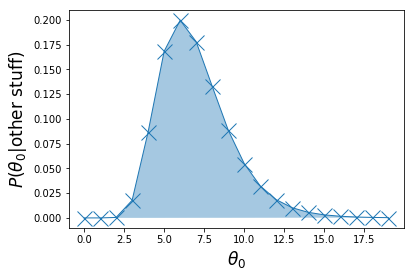

In [4]:
pad.plot_normalised_1d(theta_0_1d, log_posterior_1d)

## 2D grid (20 x 20 = 400 evaluations of the posterior)

In [5]:
theta_0, theta_1 = np.mgrid[prior_min:prior_max:n_grid*1j,prior_min:prior_max:n_grid*1j]
theta_0 = theta_0.flatten()
theta_1 = theta_1.flatten()

In [6]:
log_posterior = np.zeros(theta_0.shape)

for i in range(len(log_posterior)):
    log_posterior[i] = pad.log_function_nd([theta_0[i], theta_1[i]])

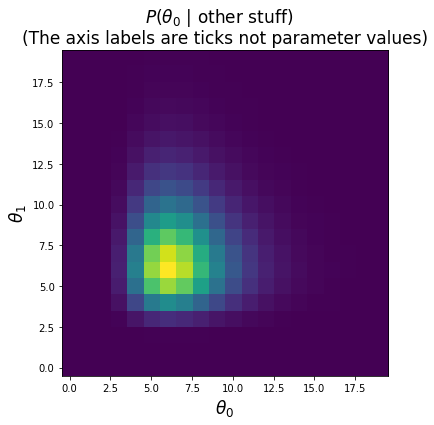

In [7]:
pad.plot_normalised_2d(log_posterior, n_grid)

### Plot with sigma contours and also the individual marginalised

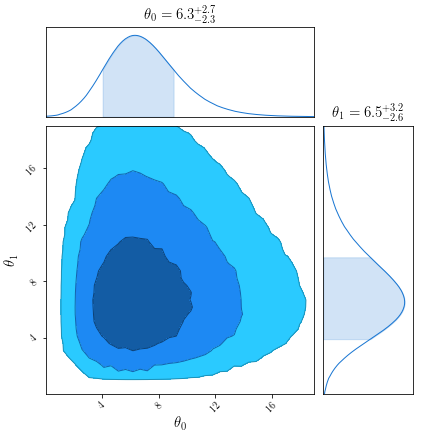

In [8]:
pad.plot_chainconsumer_2d(theta_0, theta_1, log_posterior)

## 6 dimensions (e.g. 20^6 ~ 60 million evaluations of the posterior)

In [9]:
theta_0, theta_1, theta_2, theta_3,\
theta_4, theta_5 = np.mgrid[prior_min:prior_max:n_grid*1j,
                            prior_min:prior_max:n_grid*1j,
                            prior_min:prior_max:n_grid*1j,
                            prior_min:prior_max:n_grid*1j,
                            prior_min:prior_max:n_grid*1j,
                            prior_min:prior_max:n_grid*1j]

theta_0 = theta_0.flatten()
theta_1 = theta_1.flatten()
theta_2 = theta_2.flatten()
theta_3 = theta_3.flatten()
theta_4 = theta_4.flatten()
theta_5 = theta_5.flatten()

In [10]:
# This will take forever...

log_posterior_6d = np.zeros(theta_0.shape)
t = time.time()

for i in range(len(log_posterior_6d)):
    log_posterior_6d[i] = pad.log_function_nd([theta_0[i],
                                               theta_1[i],
                                               theta_2[i],
                                               theta_3[i],
                                               theta_4[i],
                                               theta_5[i]])
    
    
    # This breaks the loop after a given number of iterations
    if pad.break_condition(i, 5*10**5, len(log_posterior_6d), time_val=t) == True:
        break
    

time to do 0.78125% is 48.81358623504639


# MCMC to the rescue!

In [11]:
# initialise sampler (new function includes a hard prior for MCMC)

n_dim6d=6
n_burn6d=100
n_steps6d = 4000
n_walkers6d = 2 * n_dim6d

theta6d_expected_mean = [10]*n_dim6d

theta_init_6d = [list(pad.initial_parameters(theta6d_expected_mean, 0.1)) for i in range(n_walkers6d)]

sampler6d = mc.EnsembleSampler(n_walkers6d, n_dim6d, pad.posterior6d_hard_prior,
                             args=(prior_min, prior_max))

In [12]:
print('burning')
startTime=time.time()
pos, prob, state =  sampler6d.run_mcmc(theta_init_6d, n_burn6d)
read_chain=np.array(sampler6d.chain[:,:,:])
endTime=time.time()
totalTime=endTime-startTime
print(totalTime)

burning
0.26470398902893066


In [13]:
# sampler.reset() #lose the written chain
t = time.time()
pos,prob,state=sampler6d.run_mcmc(pos, n_steps6d+n_burn6d) #start from where we left off previously 

print(time.time() - t)
read_chain=np.array(sampler6d.chain[:,n_burn6d:,:]) #get chain for writing
read_chain=read_chain.astype(float)


6.970337867736816


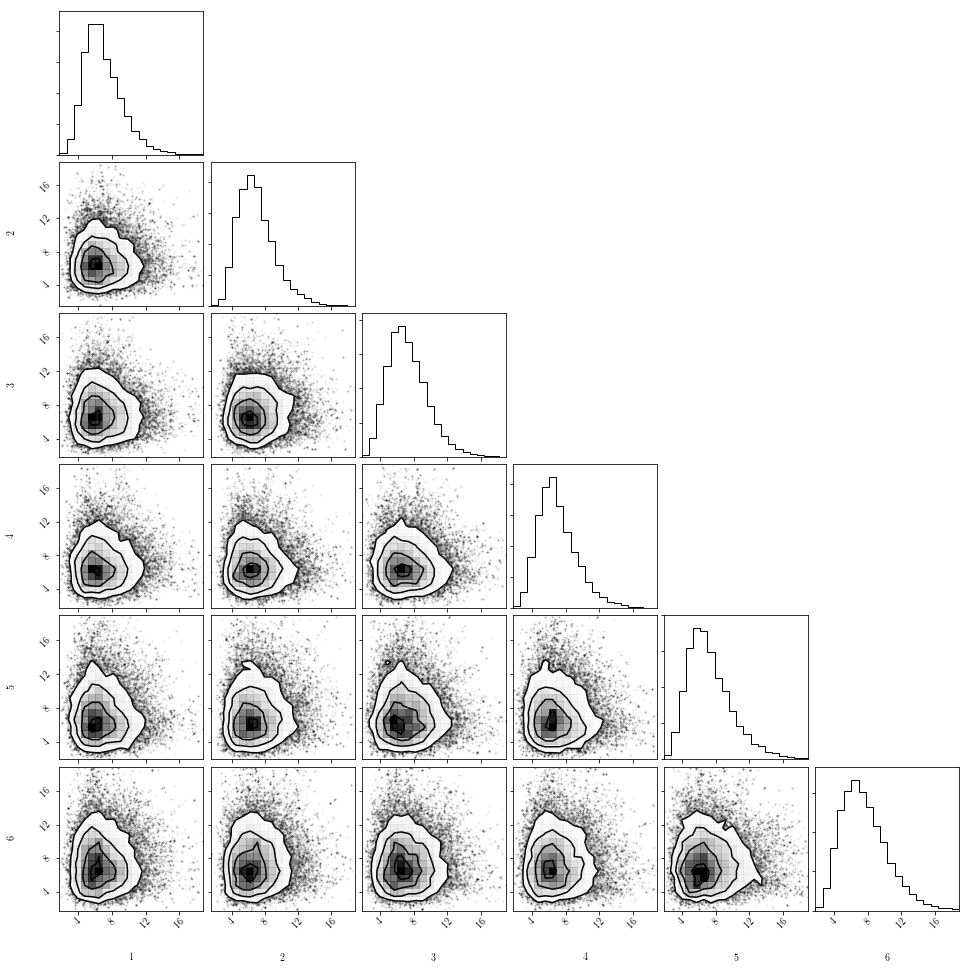

In [14]:
samples6d = read_chain.reshape((-1, n_dim6d))
fig = corner.corner(samples6d, labels=['1', '2', '3', '4', '5', '6'])

## Use it for the low dimensional stuff?

In [15]:
n_burn1d=1000
n_steps1d = 1200
n_samples1d = 2 * (n_steps1d - n_burn1d)
n_walkers1d = 2

print('Number of samples = ' + str(n_samples1d))

theta_init_1d = [list(pad.initial_parameters([10], 0.1)) for i in range(2)]

Number of samples = 400


In [16]:
sampler1d = mc.EnsembleSampler(n_walkers1d, 1, pad.posterior6d_hard_prior,
                             args=(prior_min, prior_max))


In [17]:
pos, prob, state =  sampler1d.run_mcmc(theta_init_1d, n_steps1d)
samples1d=np.array(sampler1d.chain[:,n_burn1d:,:]).flatten()

In [18]:
theta_0_1d_fine = np.linspace(prior_min,prior_max,n_grid*10-9)

log_posterior_1d_fine = np.zeros(theta_0_1d_fine.shape)

for i in range(len(log_posterior_1d_fine)):
    log_posterior_1d_fine[i] = pad.log_function_nd([theta_0_1d_fine[i]]) 


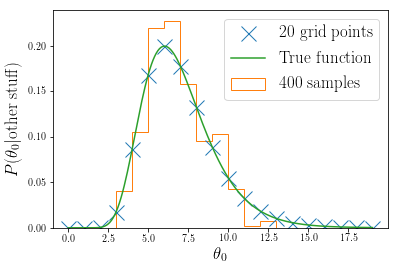

In [19]:
_ = plt.plot(theta_0_1d, np.exp(log_posterior_1d)/np.sum(np.exp(log_posterior_1d)), marker = 'x', ms = 15,  lw=0, label = '20 grid points')
_ = plt.hist(samples1d, normed = True, histtype ='step', bins = np.linspace(0,19,20), label = str(n_samples1d) + ' samples')
_ = plt.plot(theta_0_1d_fine, 10.0*np.exp(log_posterior_1d_fine)/np.sum(np.exp(log_posterior_1d_fine)),  label = 'True function')
_ = plt.ylabel(r'$P(\theta_0| \rm{other\ stuff})$', fontsize = 17), plt.xlabel(r'$\theta_0$', fontsize = 17)
_ = plt.legend(fontsize = 17)

# If the samples match the underlying distribution, the MCMC has "converged"